<a href="https://colab.research.google.com/github/tlerksuthirat/lab_management/blob/main/Trim_certain_decibel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import librosa
import numpy as np
import soundfile as sf

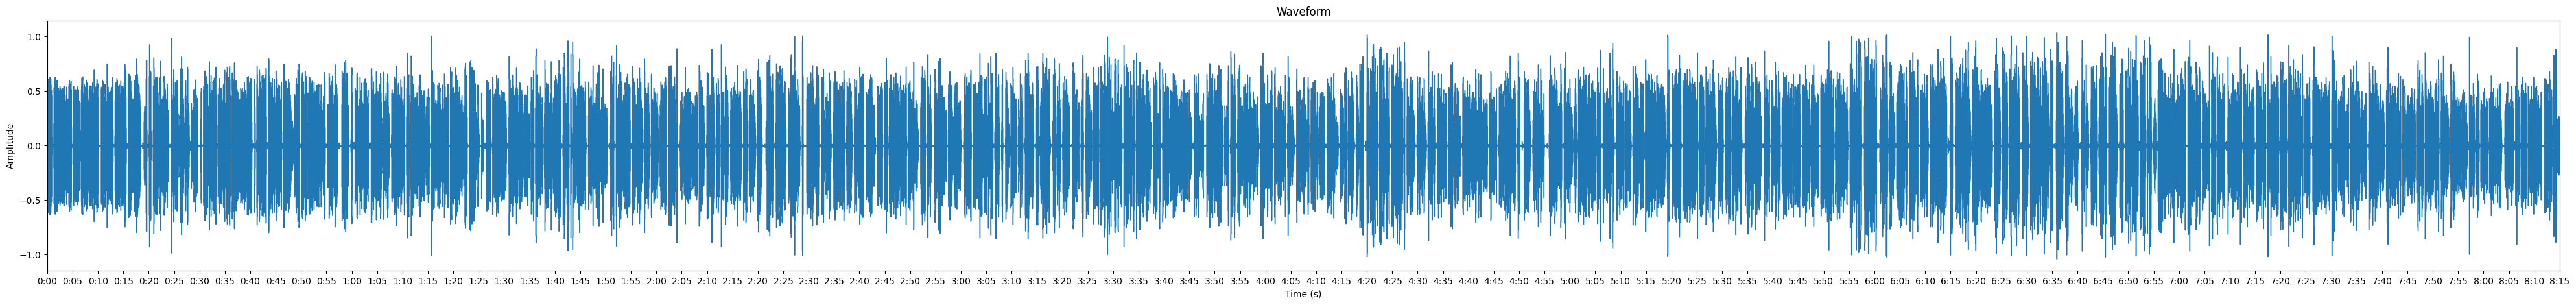

In [4]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

# Load the audio file
# You can download the data from: https://github.com/tlerksuthirat/sample-dataset/blob/master/%E0%B8%AA%E0%B8%B8%E0%B8%82%E0%B8%A0%E0%B8%B2%E0%B8%9E%E0%B8%AD%E0%B8%87%E0%B8%84%E0%B9%8C%E0%B8%A3%E0%B8%A7%E0%B8%A1%E0%B9%83%E0%B8%99%E0%B8%97%E0%B8%B5%E0%B9%88%E0%B8%97%E0%B8%B3%E0%B8%87%E0%B8%B2%E0%B8%99_%20%E0%B8%84%E0%B8%A7%E0%B8%B2%E0%B8%A1%E0%B8%97%E0%B9%89%E0%B8%B2%E0%B8%97%E0%B8%B2%E0%B8%A2%E0%B9%81%E0%B8%A5%E0%B8%B0%E0%B8%81%E0%B8%B2%E0%B8%A3%E0%B9%81%E0%B8%81%E0%B9%89%E0%B9%84%E0%B8%82.wav
audio_file = 'สุขภาพองค์รวมในที่ทำงาน_ ความท้าทายและการแก้ไข.wav'
y, sr = librosa.load(audio_file)

# Get the duration of the audio in seconds
duration = librosa.get_duration(y=y, sr=sr)

# Display the waveform with a wider figure
plt.figure(figsize=(50, 5))
librosa.display.waveshow(y, sr=sr)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

# Set x-axis ticks for a finer scale (e.g., every 5 seconds)
plt.xticks(np.arange(0, duration + 1, 5))
plt.xlim(0, duration) # Ensure the x-axis covers the entire duration

plt.show()

In [32]:
def manual_trim_and_merge(audio_path, output_path, db_threshold=-45, min_segment_len_ms=500):
    """
    Manually trims and merges audio segments based on RMS energy, then concatenates them.
    This is a more explicit example of how to do it if not using pydub's helper.

    Args:
        audio_path (str): Path to the input audio file.
        output_path (str): Path to save the processed audio file.
        db_threshold (int): RMS energy below this dB is considered silence.
        min_segment_len_ms (int): Minimum length of a non-silent segment to be kept.
    """
    y, sr = librosa.load(audio_path, sr=None)

    # Define frame and hop lengths for RMS calculation
    frame_length = 2048
    hop_length = 512

    # Calculate RMS energy
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]

    # Convert RMS to dB
    rms_db = librosa.amplitude_to_db(rms, ref=np.max)

    # Identify non-silent frames
    non_silent_frame_indices = np.where(rms_db > db_threshold)[0]

    # Find contiguous non-silent segments
    non_silent_segments = []
    start_frame = non_silent_frame_indices[0]
    for i in range(1, len(non_silent_frame_indices)):
        if non_silent_frame_indices[i] != non_silent_frame_indices[i-1] + 1:
            end_frame = non_silent_frame_indices[i-1]
            if (end_frame - start_frame) * hop_length / sr * 1000 >= min_segment_len_ms:
                non_silent_segments.append((start_frame, end_frame))
            start_frame = non_silent_frame_indices[i]

    # Add the last segment
    end_frame = non_silent_frame_indices[-1]
    if (end_frame - start_frame) * hop_length / sr * 1000 >= min_segment_len_ms:
        non_silent_segments.append((start_frame, end_frame))

    # Convert frame indices to sample indices and concatenate audio
    merged_audio = np.array([])
    for start_frame, end_frame in non_silent_segments:
        start_sample = start_frame * hop_length
        end_sample = end_frame * hop_length + frame_length
        merged_audio = np.concatenate((merged_audio, y[start_sample:end_sample]))

    # Save the processed audio
    sf.write(output_path, merged_audio, sr)

# Example usage:
input_audio = 'สุขภาพองค์รวมในที่ทำงาน_ ความท้าทายและการแก้ไข.wav'
output_audio = 'processed_audio.wav'
manual_trim_and_merge(input_audio, output_audio)

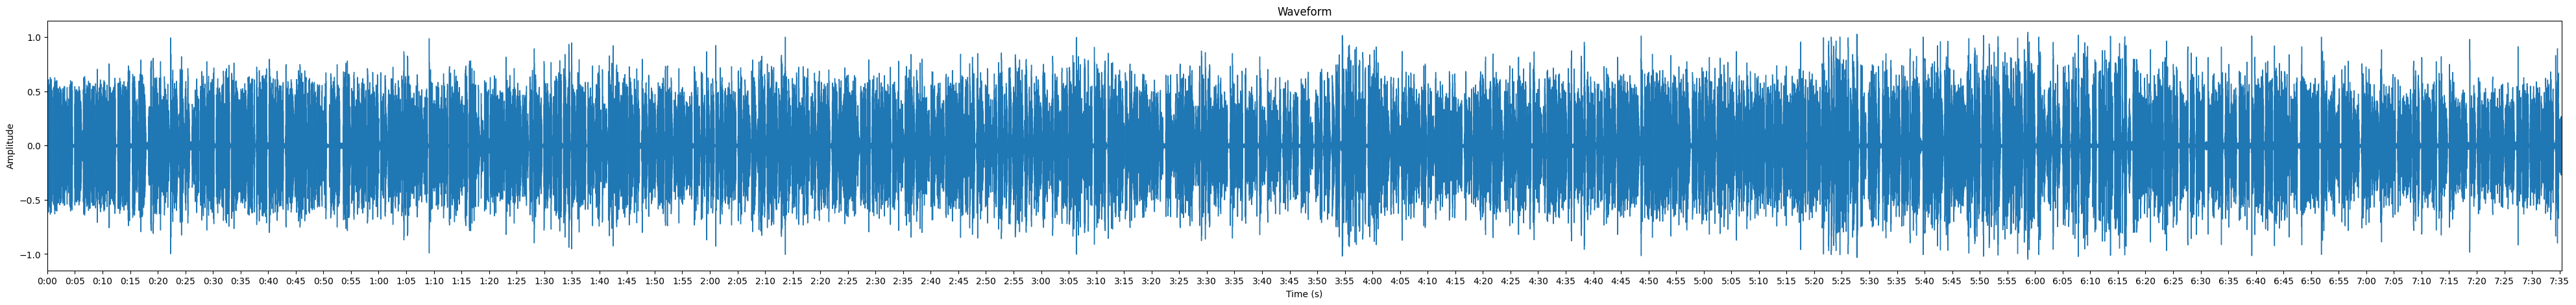

In [29]:
# Recheck the wave
audio_file_edit = 'processed_audio.wav'
y, sr = librosa.load(audio_file_edit)

duration = librosa.get_duration(y=y, sr=sr)

plt.figure(figsize=(50, 5))
librosa.display.waveshow(y, sr=sr)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

plt.xticks(np.arange(0, duration + 1, 5))
plt.xlim(0, duration)

plt.show()

In [1]:
# Install yt-dlp and pydub
!pip install pytube
!pip install --force-reinstall yt-dlp pydub
!apt-get install -y ffmpeg

import yt_dlp
from pydub import AudioSegment
import os

# --- Your YouTube Link Goes Here ---
youtube_url = 'https://youtu.be/v7V6uhSYbbc?si=ep4uUyQbDT_RMJj_'
# ------------------------------------

print(f"Downloading audio from: {youtube_url}")

# Define the output template
output_template = '%(title)s.%(ext)s'
final_wav_filename = ""

# Set up yt-dlp options for audio download
ydl_opts = {
    'format': 'bestaudio/best',
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'wav',
        'preferredquality': '192',
    }],
    'outtmpl': output_template.replace('.%(ext)s', ''), # Set template without extension for postprocessor
    'ignoreerrors': True, # Add ignore-errors flag
}

# Download and convert audio using yt-dlp
with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    info_dict = ydl.extract_info(youtube_url, download=True)
    video_title = info_dict.get('title', 'downloaded_video')
    # The postprocessor will add the .wav extension
    final_wav_filename = f"{video_title}.wav"

if os.path.exists(final_wav_filename):
    print(f"\nSuccessfully downloaded and converted audio.")
    print(f"The file is saved as: '{final_wav_filename}'")
else:
    print("\nDownload failed or file was not converted to WAV correctly.")

  Using cached yt_dlp-2025.7.21-py3-none-any.whl.metadata (175 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached yt_dlp-2025.7.21-py3-none-any.whl (3.3 MB)
Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)
  Attempting uninstall: pydub
    Found existing installation: pydub 0.25.1
    Uninstalling pydub-0.25.1:
      Successfully uninstalled pydub-0.25.1
  Attempting uninstall: yt-dlp
    Found existing installation: yt-dlp 2025.7.21
    Uninstalling yt-dlp-2025.7.21:
      Successfully uninstalled yt-dlp-2025.7.21
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
[youtube] Extracting URL: https://youtu.be/v7V6uhSYbbc?si=ep4uUyQbDT_RMJj_
[youtube] v7V6uhSYbbc: Downloading webpage
[youtube] v7V6uhSYbbc: Downloading tv client config
[youtube] v7V6uhSYbbc: Downloading tv player

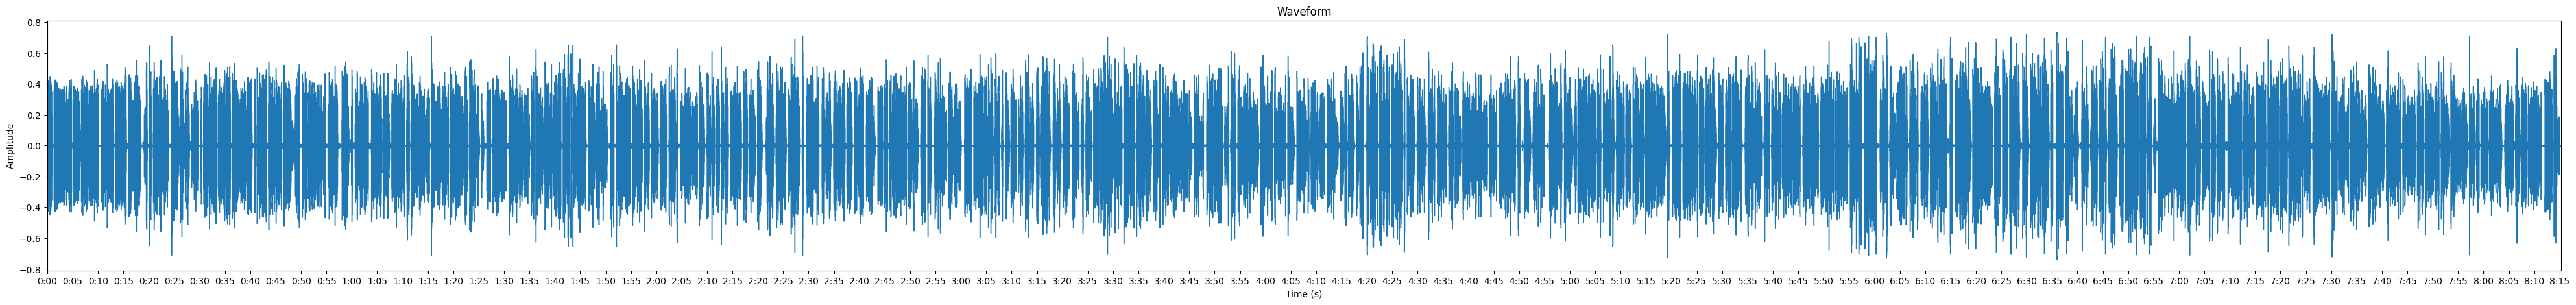

In [5]:
y, sr = librosa.load('Video used for demonstrating dead air removal using Python #python #soundprocessing.wav')

# Get the duration of the audio in seconds
duration = librosa.get_duration(y=y, sr=sr)

# Display the waveform with a wider figure
plt.figure(figsize=(50, 5))
librosa.display.waveshow(y, sr=sr)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

# Set x-axis ticks for a finer scale (e.g., every 5 seconds)
plt.xticks(np.arange(0, duration + 1, 5))
plt.xlim(0, duration) # Ensure the x-axis covers the entire duration

plt.show()

In [9]:
from pydub import AudioSegment
from pydub.silence import split_on_silence

# Load your audio file
audio = AudioSegment.from_wav("Video used for demonstrating dead air removal using Python #python #soundprocessing.wav")

# Split the audio into chunks where silence is 500ms or longer and the threshold is -40dBFS
# - min_silence_len: (in ms) minimum length of a silence to be used for splitting.
# - silence_thresh: (in dBFS) anything quieter than this will be considered silence.
# - keep_silence: (in ms) adds a bit of silence at the beginning and end of the chunks.
#                  This helps to prevent the audio from sounding too abrupt.
chunks = split_on_silence(
    audio,
    min_silence_len=500,
    silence_thresh=-25,
    keep_silence=200
)

# Combine the non-silent chunks
output_audio = AudioSegment.empty()
for chunk in chunks:
    output_audio += chunk

# Export the result
output_filename = "youtube_audio_trimmed.wav"
output_audio.export(output_filename, format="wav")

print(f"Removed dead air. The result is saved as '{output_filename}'")

Removed dead air. The result is saved as 'youtube_audio_trimmed.wav'


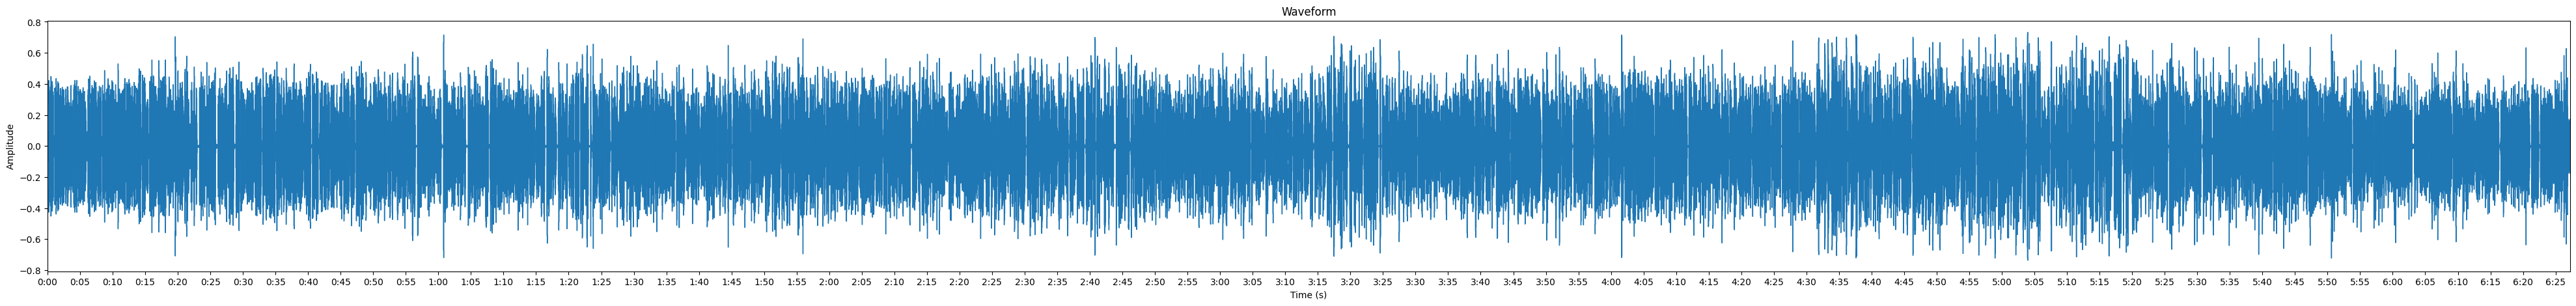

In [10]:
y, sr = librosa.load('youtube_audio_trimmed.wav')

# Get the duration of the audio in seconds
duration = librosa.get_duration(y=y, sr=sr)

# Display the waveform with a wider figure
plt.figure(figsize=(50, 5))
librosa.display.waveshow(y, sr=sr)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

# Set x-axis ticks for a finer scale (e.g., every 5 seconds)
plt.xticks(np.arange(0, duration + 1, 5))
plt.xlim(0, duration) # Ensure the x-axis covers the entire duration

plt.show()